# Import Libraries

In [4]:
#install quandl
conda install quandl

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\byl19\anaconda3

  added / updated specs:
    - quandl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-23.3.1               |   py39haa95532_0         972 KB
    jsonpatch-1.32             |     pyhd3eb1b0_0          15 KB
    jsonpointer-2.1            |     pyhd3eb1b0_0           9 KB
    more-itertools-8.12.0      |     pyhd3eb1b0_0          49 KB
    quandl-3.6.1               |   py39haa95532_0          53 KB
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following NEW packages will be INSTALLED:

  jsonpatch          pkgs/main/noarch::jsonpatch-1.32-pyhd3eb1b0_0 
  jsonpointer        pkgs/main/noarch::jsonpointer-2.1-pyhd3eb1b0_0 
  more-itertools     pkgs/

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
%matplotlib inline

# Import Data

In [3]:
path = r'C:/Users/byl19/Acheivment 6/Acheivment 6'

In [4]:
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'Cleaned-Oil-Data.csv'))

# Exercise

#### For this data set, a subset will not be necessary. The data in this dataset is from 2010 to 2017 and there are no historical events that would bias this data that I can think of. It also does not include any forecasted data as it only includes oil spills up until 2017.

#### Since our dataset only contains 8 years of data, splitting the count of oil spills by year would not give us enough datapoints to accuratley define trends in the data, therefore, I will split the count of oil spills by month which is also included in our dataframe.

In [5]:
df.columns

Index(['Report Number', 'Accident Year', 'Accident Date', 'Accident Time',
       'Operator ID', 'Operator Name', 'Pipeline/Facility Name',
       'Pipeline Location', 'Pipeline Type', 'Liquid Type', 'Accident City',
       'Accident County', 'Accident State', 'Cause Category',
       'Cause Subcategory', 'Unintentional Release (Barrels)',
       'Intentional Release (Barrels)', 'Liquid Recovery (Barrels)',
       'Net Loss (Barrels)', 'Liquid Ignition', 'Liquid Explosion',
       'Pipeline Shutdown', 'Shutdown Date/Time', 'Restart Date/Time',
       'Public Evacuations', 'Property Damage Costs', 'Lost Commodity Costs',
       'Public/Private Property Damage Costs', 'Emergency Response Costs',
       'Environmental Remediation Costs', 'Other Costs', 'All Costs',
       'Time Category', 'Accident Date/Time'],
      dtype='object')

In [6]:
df2 = df[['Accident Date/Time']]

In [7]:
df2.head()

,Accident Date/Time
0,1/26/2015 9:38
1,1/10/2015 20:45
2,3/12/2013 17:46
3,8/12/2013 23:10
4,7/29/2013 0:00


In [8]:
#convert to datetime
df2['Accident Date/Time'] = pd.to_datetime(df2['Accident Date/Time'])

In [9]:
#seperate by year and month
df2['month'] = df2['Accident Date/Time'].dt.month

In [10]:
df2['year'] = df2['Accident Date/Time'].dt.year

In [11]:
#count values by year and month
grouped = df2.groupby(['year', 'month']).size().reset_index(name='Count')

In [12]:
grouped.head()

,year,month,Count
0,2010,1,34
1,2010,2,16
2,2010,3,32
3,2010,4,32
4,2010,5,30


In [13]:
#combine year and month back together
grouped['year_month'] = grouped['year'].astype(str) + '-' + grouped['month'].astype(str).str.zfill(2)

In [14]:
#convert to datetime
grouped['year_month'] = pd.to_datetime(grouped['year_month'])

In [15]:
#drop year and month columns
grouped = grouped.drop(columns=['year', 'month'])

In [16]:
#set the date as index
grouped = grouped.set_index('year_month')

In [17]:
grouped.tail()

,Count
year_month,
2016-09-01,31
2016-10-01,33
2016-11-01,29
2016-12-01,33
2017-01-01,2


In [18]:
#drop last row 
grouped = grouped.drop('2017-01-01')

#### Linechart

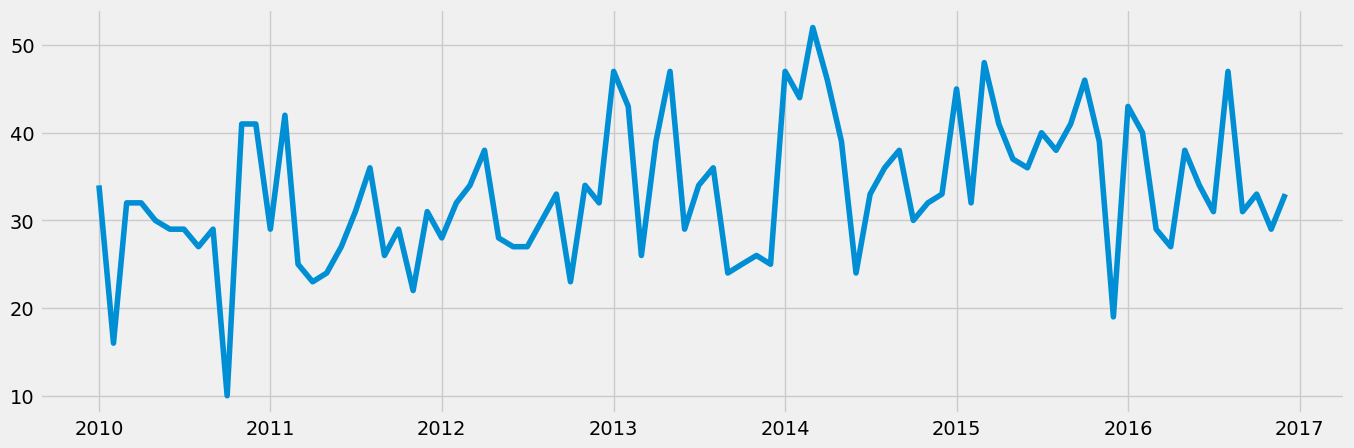

In [19]:
#line chart of data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(grouped)

In [59]:
#smooth data using Savitzky-Golay Filter
from scipy.signal import savgol_filter
grouped['smooth'] = savgol_filter(grouped['Count'], window_length=20, polyorder=3)

In [60]:
grouped2 = grouped.drop(columns=['Count'])

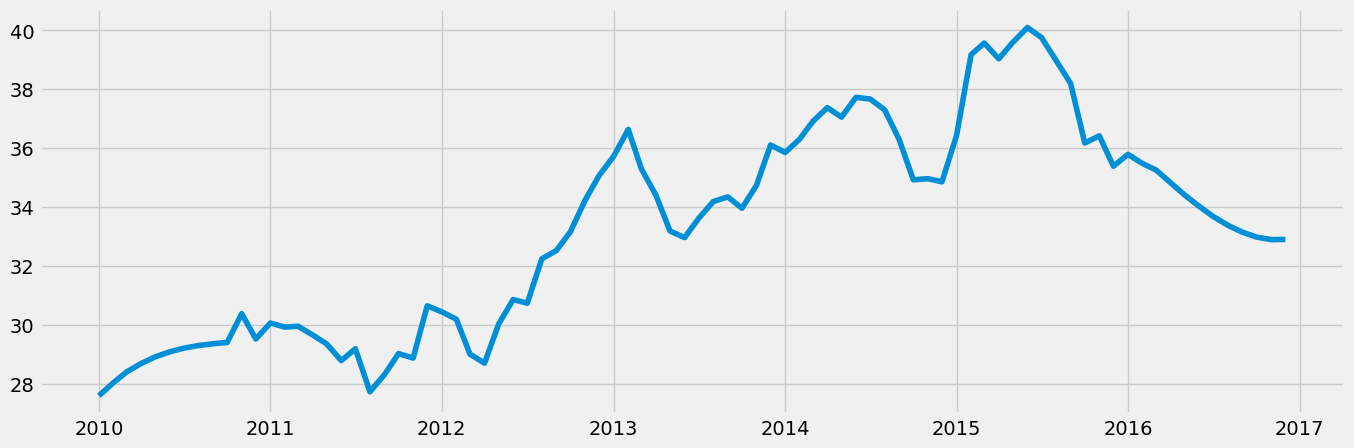

In [61]:
#smoothed linechart
plt.figure(figsize=(15,5), dpi=100)
plt.plot(grouped2)

#### Decompose

In [62]:
#since our model is linear we will use the additive model
decomposition = sm.tsa.seasonal_decompose(grouped2, model='additive')

In [63]:
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

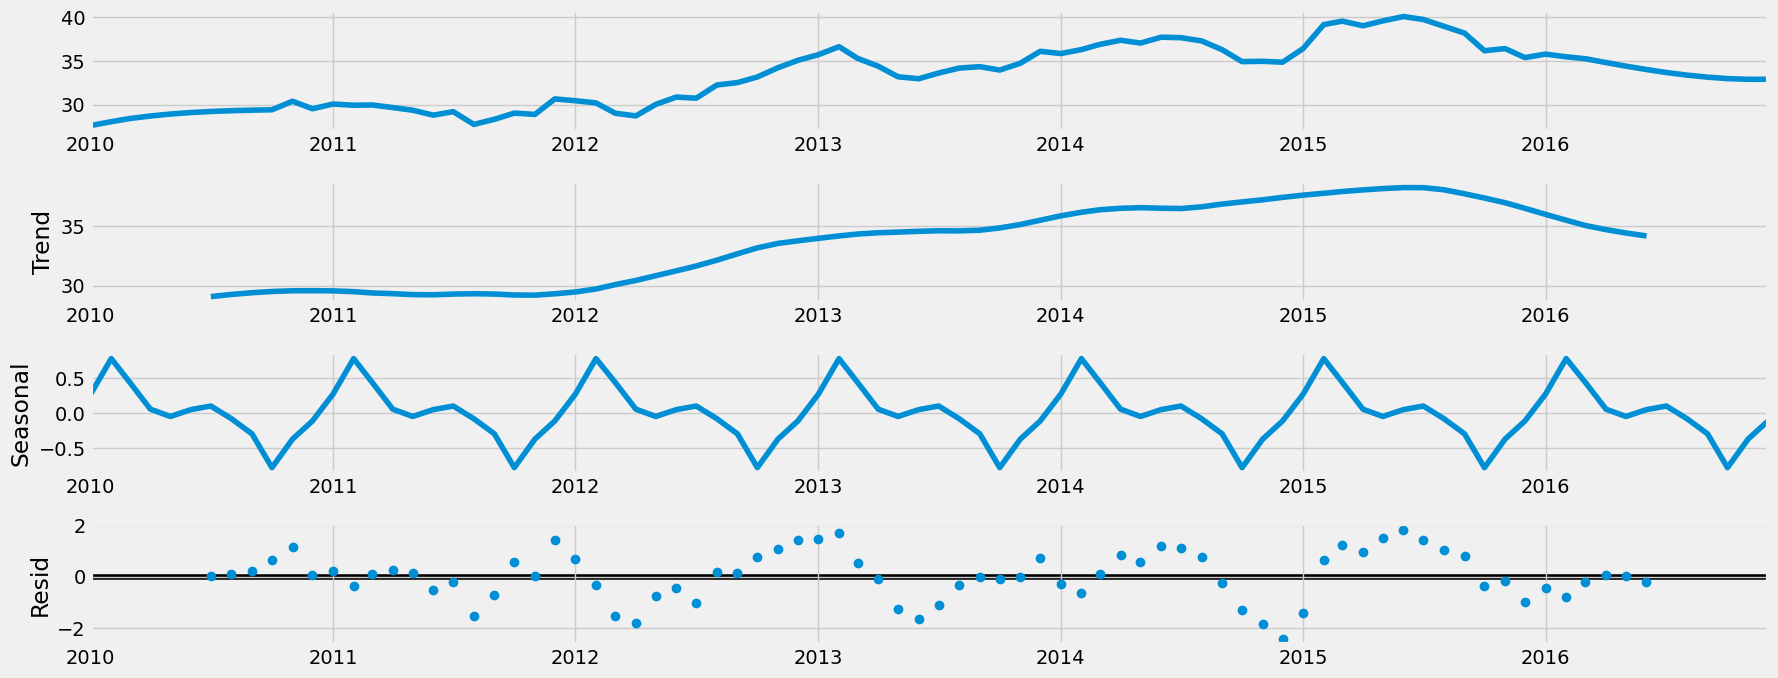

In [64]:
decomposition.plot()
plt.show()

#### Looking at this decompisition we can tell that we are working with a non-stationary time series since there isn a precense of a trend and seasonality. With the smoothing, I was able to get my trend line close to what the level shows. Even with smoothing there is still a bit of residual which means there is a bit of unexplained noise when it comes to the count of oils spills per month. 

#### Stationary Testing

In [65]:
#Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)


In [66]:
dickey_fuller(grouped2['smooth'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.732150
p-value                         0.414629
Number of Lags Used             1.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


#### Based on these results our data is not stationary (which we already knew) and there is a unit root within the data meaning I cannot reject the null-hypothesis becasue the test statistic is higher than our critical values

#### Differenceing 

In [68]:
data_diff = grouped2 - grouped2.shift(1)

In [69]:
data_diff.dropna(inplace = True)

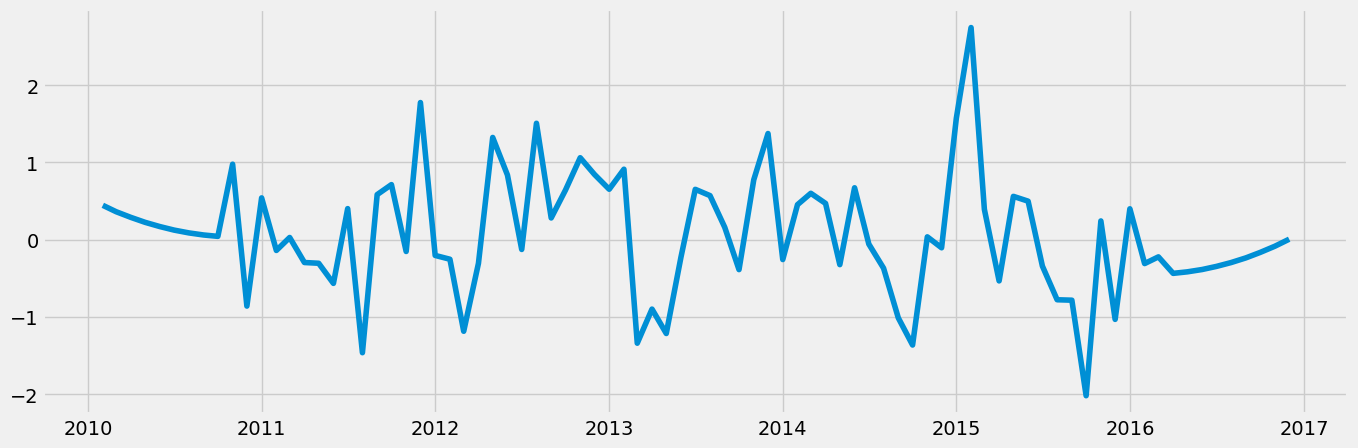

In [70]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [71]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.983889e+00
p-value                        8.061032e-10
Number of Lags Used            0.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (1%)           -3.512738e+00
Critical Value (5%)           -2.897490e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


#### Based on these numbers our data is not stationary and we can reject the null hypothesis

In [72]:
#autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

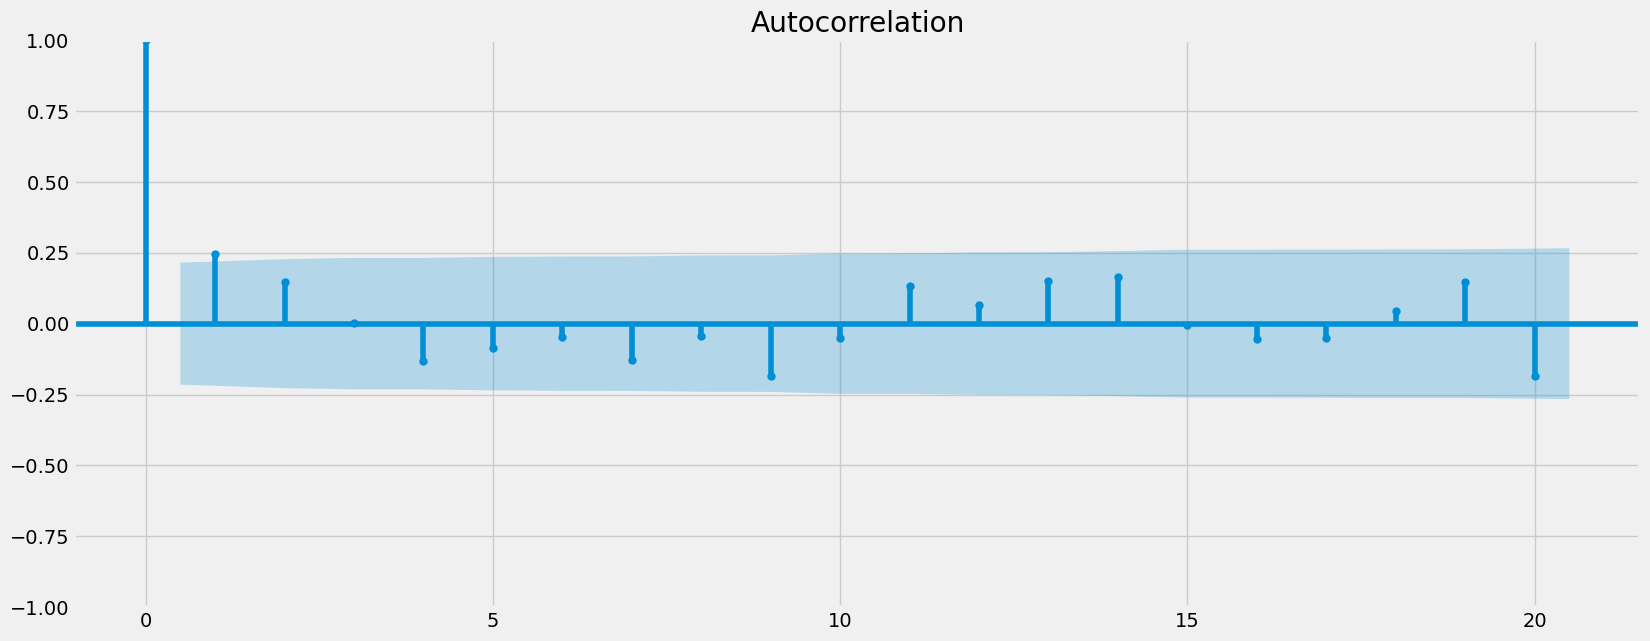

In [73]:
plot_acf(data_diff)
plt.show()